# Pursuit curves
Given a target curve and a positive scalar $q$, a $q$-pursuit curve is a curve $\mathcal{C}$ together with a continuous mapping $\pi$ (the tangential projection) from $\mathcal{C}$ onto the target curve such that
* for any point $P$ of $\mathcal{C}$, the tangent to $\mathcal{C}$ at $P$ contains $\pi(P)$;
* for any points $P_1,P_2$ of $\mathcal{C}$, the length on the target curve of the arc $\pi(P_1),\pi(P_2)$ is $q$ time the length on $\mathcal{C}$ of the arc $P_1,P_2$.

Given:
* a pair $A,\hat{A}$ of reference points
* a scalar $q>0$ and a target curve containing $\hat{A}$

we seek to determine the $q$-pursuit curves which contain $A$ and such that the tangential projection of $A$ onto the target be $\hat{A}$.

In [1]:
%pylab nbagg
# for better display performance, use default backend

import logging
from functools import partial
from ipyshow.odesimu.system import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


## Simulation
We assume the target curve is given by an arbitrary parametrisation $(X(t),Y(t))$. Parameter $t$ is interpreted as time so that the target curve can be viewed as the trajectory of a point, called the leader. For more generality, we assume that $(X,Y)$ is not given directly but obtained as the solution of a given ODE (dynamics equation):
\begin{equation*}
(\dot{X}(t),\dot{Y}(t)) = F(t,(X(t),Y(t)))
\end{equation*}
Initially (at time $t=0$) we assume that the leader is in $\hat{A}$ with coordinates $(X_o,Y_o)$, hence the initial condition of the ODE is $(X(0),Y(0))=(X_o,Y_o)$.

A $q$-pursuit curve can then also be parametrised by the same time parameter, and be obtained as the trajectory of an other point called the pursuer with coordinates $(x,y)$, initially in $A$ with coordinates $(x_o,y_o)$. The equations of the whole system (leader and pursuer) are therefore:
\begin{equation*}
(\dot{X},\dot{Y}) = F(t,(X,Y))
\hspace{2cm}
q\sqrt{\dot{x}^2+\dot{y}^2} = \sqrt{\dot{X}^2+\dot{Y}^2}
\hspace{2cm}
\begin{array}{|cc|}x-X & \dot{x}\\ y-Y & \dot{y}\end{array}=0
\end{equation*}
with initial conditions
\begin{equation*}
x(0),y(0)=x_o,y_o
\hspace{2cm}
X(0),Y(0)=X_o,Y_o
\end{equation*}
The program below uses a standard package to numerically solve this ODE. The state is taken to be the quadruple $x,y,X,Y$ (pursuer: first two components; leader: last two components). Observe that the equation is not in completely explicit form. Indeed, there are two ways to put it in explicit form, depending on the sign used in the following expression:
\begin{equation*}
\left(\begin{array}{c}\dot{x}\\\dot{y}\end{array}\right) =
\pm\frac{1}{q}\sqrt{\frac{||F(t,(X,Y))||^2}{(x-X)^2+(y-Y)^2}}
\left(\begin{array}{c}x-X\\y-Y\end{array}\right) 
\end{equation*}
corresponding to two situations: the pursuer moves toward the leader (positive sign) or away from the leader (negative sign, the pursuer should be called an escaper in that case!). However, it is easy to show that both cases yield the same pursuit curve. Only, the trajectory of the pursuer along that curve in one case is reversed with respect to that in the other case.

On the other hand, if the target curve is given by the ODE associated with $F$, then the ODE associated with $F^\bot$ where $F^\bot(t,(X,Y))\triangleq-F(-t,(X,Y))$ describes the same target curve. The trajectory of the leader along that curve is simply reversed. But in that case, the $q$-pursuit curve, given the same initial conditions, will be different. Indeed, there are two possible $q$-pursuit curves for a given pair $A,\hat{A}$, and they correspond to the choice between $F$ and $F^\bot$. Given one choice, the other can be recovered by flipping the sign of $q$ in the equations. The program below supports $q<0$ for that purpose.

In [2]:
def norm(x): return sqrt(square(x[0])+square(x[1]))

class Pursuit (System):

    shadowshape = (4,)

    def __init__(self,q,F,epsilon=1e-3):
        """Parameters q,F are those defining the ODE above"""
        assert q
        self.q = q
        if q<0: F = (lambda t,pos,F=F: -F(-t,pos))
        self.F = F
        self.epsilon = epsilon
        def main(t,state,q=abs(q)):
            v = F(t,state[2:4])
            p = state[2:4]-state[0:2]
            d = norm(p)
            if d<epsilon: return concatenate((v,v))
            p /= q*d ; p *= norm(v)
            return concatenate((p,v))
        self.main = main
        self.fordisplay = lambda state: (state, state)

    def display(self,ax,**ka):
        ax.set_aspect('equal')
        s_pursuer = ax.scatter((),(),color='b',s=50,marker='^',label='pursuer')
        s_leader = ax.scatter((),(),color='g',s=50,marker='v',label='leader')
        p_tail = ax.plot((),(),'b',(),(),'g')
        p_tan, = ax.plot((),(),c='k',ls=':')
        ax.legend(fontsize='small',loc='lower right')
        def disp(t,live,tail):
            s_pursuer.set_offsets((live[0:2],))
            s_leader.set_offsets((live[2:4],))
            p_tail[0].set_data(tail[:,0],tail[:,1])
            p_tail[1].set_data(tail[:,2],tail[:,3])
            if norm(live[0:2]-live[2:4])<self.epsilon:
                for a in s_pursuer, s_leader: a.set_color('r')
            else: p_tan.set_data((live[0],live[2]),(live[1],live[3]))
        return super().display(ax,disp,**ka)

    launchdefaults = dict(
        maxtime=infty,
        srate=25.,
        taild=10,
        animate=dict(repeat=False,),
    )

### An example: parabolic target
Consider the case where the leader moves with constant horizontal speed $v$ and constant vertical acceleration $g$ with no initial vertical speed. The target curve is therefore a parabola. The ODE of the leader is defined by
\begin{equation*}
F(t,(X,Y)) = (v,g\frac{X}{v})
\hspace{1cm}\textrm{or alternatively}\hspace{1cm}
F(t,(X,Y)) = (v,gt)
\end{equation*}
We assume that reference point $\hat{A}$ (initial position of the leader) is taken as the origin of the reference frame (hence $X_o,Y_o=0$).

In [3]:
class ParabolaPursuit (Pursuit):
    def __init__(self,v=1.,g=-1.,**ka):
        super().__init__(F=(lambda t,pos,r=g/v: array((v,r*pos[0]))),**ka)
        self.v, self.g = v,g
    def display(self,ax,ini,h=1.,**ka):
        x = linspace(-h*ini[0],h*ini[0],100)
        ax.plot(x,self.g*square(x/self.v)/2.,c='g',ls='--')
        return super().display(ax,ini=ini,**ka)
    @staticmethod
    def makestate(xo,yo): return array((xo,yo,0.,0.))

Launchers
---------

System parameters:
* `q`: the arc length ratio between target and pursuit curve
* `v`: horizontal speed of the leader (in m.sec$^{-1}$)
* `g`: vertical acceleration of the leader (in m.sec$^{-2}$)

Launch parameters:
* `ini/xo`, `ini/yo`: departure point of the pursuer (in m); the leader departs from $0,0$
* `srate`: simulation rate (in frames.sec$^{-1}$)
* `taild`: duration of shadow, ie. trace of previous states (in sec)
* `hooks`: list of display hooks (see doc)

<IPython.core.display.Javascript object>


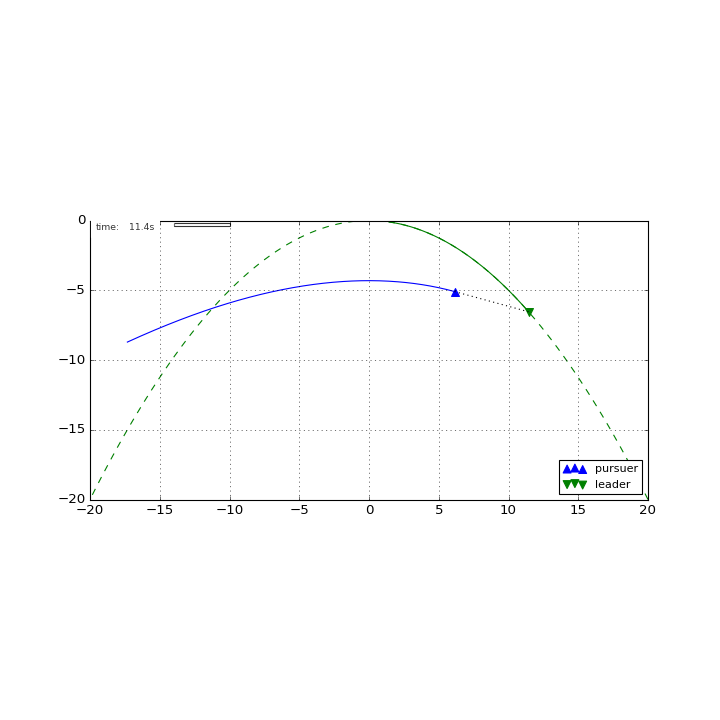

In [4]:
syst = ParabolaPursuit(q=.5,g=-.1); ini = dict(xo=-20.,yo=-10.)
syst.launch(ini=syst.makestate(**ini))

## Analytic solutions
We now assume that the target curve is also given by its natural parametrisation $\hat{x}(s),\hat{y}(s)$, where the parameter $s$ is the arc length (on the target curve) measured from reference point $\hat{A}$. Hence, by construction $\hat{A}$ has coordinates $\hat{x}(0),\hat{y}(0)$ and the equation $\hat{x}'^2+\hat{y}'^2=1$ holds.

Let $x,y$ be some parametrisation of a $q$-pursuit curve, i.e. $x(u),y(u)$ are functions of some parameter $u$. Let $u_o$ be the parameter of the reference point $A$ and $\ell(u)$ be the length on the pursuit curve of the arc between $A$ and the point of parameter $u$. The equations of a $q$-pursuit curve are given by
\begin{equation*}
\ell' = \pm\sqrt{x'^2+y'^2}
\hspace{2cm}
\begin{array}{|cc|}
x-\hat{x}(q\ell) & x'\\
y-\hat{y}(q\ell) & y'
\end{array} = 0
\end{equation*}
with initial conditions
\begin{equation*}
x(u_o) = x_o \hspace{2cm} y(u_o) = y_o \hspace{2cm} \ell(u_o) = 0
\end{equation*}
There are two equations for three unknowns $x,y,\ell$, so the system is under-determined, which is not surprising since there is a degree of freedom in the choice of the parametrisation of the pursuit curve. That choice determines the system, but also the difficulty of its resolution. Note that the sign of $\ell'$ can be chosen arbitrarily: it only determines the direction followed by the chosen parametrisation along the pursuit curve, not the curve itself.

### Analytic solution when the target is a straight line

We assume the origin of the referential frame is taken to be $\hat{A}$ and the vertical axis to be the target curve itself (straight line). The natural parametrisation of the target is hence given by
\begin{equation*}
\hat{x}(s) = 0 \hspace{2cm} \hat{y}(s) = s
\end{equation*}
For the pursuit curve, we assume the parameter is the $x$-coordinate. Hence $x(u)=u$. Furthermore, without loss of generality, we can take $x_o>0$ and $\ell'<0$. The solution is given by
\begin{eqnarray*}
y & = & \frac{1}{2}(\frac{e^c}{1+q}u^{1+q}-\frac{e^{-c}}{1-q}u^{1-q})+y_*
\hspace{1cm}\textrm{if $q\not=1$ else}\hspace{1cm}
\frac{1}{2}(\frac{e^c}{1+q}u^{1+q}-e^{-c}\log(u))+y_*\\
\ell & = & -\frac{1}{2}(\frac{e^c}{1+q}u^{1+q}+\frac{e^{-c}}{1-q}u^{1-q})+\ell_*
\hspace{1cm}\textrm{if $q\not=1$ else}\hspace{1cm}
-\frac{1}{2}(\frac{e^c}{1+q}u^{1+q}+e^{-c}\log(u))+\ell_*
\end{eqnarray*}
Constants $c,y_*,\ell_*$ are given by
\begin{eqnarray*}
e^c & = & x_o^{-q}r \hspace{1cm}\textrm{where}\hspace{1cm} r \triangleq \frac{y_o}{x_o}+\sqrt{1+(\frac{y_o}{x_o})^2}\\
y_* & = & y_o-\frac{x_o}{2}\left(\frac{r}{1+q}-\frac{1}{r(1-q)}\right) 
\hspace{1cm}\textrm{if $q\not=1$ else}\hspace{1cm}
y_o-\frac{x_o}{2}\left(\frac{r}{2}-\frac{\log(x_o)}{r}\right)\\
\ell_* & = & \frac{x_o}{2}\left(\frac{r}{1+q}+\frac{1}{r(1-q)}\right)
\hspace{1cm}\textrm{if $q\not=1$ else}\hspace{1cm}
\frac{x_o}{2}\left(\frac{r}{2}+\frac{\log(x_o)}{r}\right)
\end{eqnarray*}
When $q\not=1$, we have $y_*=q\ell_*$. Furthermore, the critical point of the pursuit curve is given by
\begin{equation*}
x^* = x_or^{-\frac{1}{q}}
\hspace{2cm}
y^* = \frac{x_oq}{2}(\frac{r}{1+q}+\frac{1}{r(1-q)}-\frac{2r^{-\frac{1}{q}}}{1-q^2})
\hspace{.5cm}\textrm{if $q\not=1$ else}\hspace{.5cm}
y_o+\frac{x_o}{2}(\frac{1}{2r}-\frac{r}{2}+\frac{\log(r)}{r})
\end{equation*}
The program below augments the basic simulation by drawing before the start of the simulation a segment of the predicted pursuit curve given by the equations above, together with its remarkable points (critical point, and, when $q<1$, contact point).

In [5]:
class StraightLinePursuit (Pursuit):

    def __init__(self,v=1.0,**ka):
        super().__init__(F=(lambda t,pos,v=v*array((0,1)):v),**ka)
        def analytics(state,q=self.q):
            xo,yo,xom,yom = state
            assert xom==0 and yom==0
            r = yo/xo+sqrt(1+square(yo/xo))
            if q == 1.:
                p1 = r/(4*xo)
                p2 = xo/(2*r)
                c_y = yo-r*xo/4+xo*log(xo)/(2*r)
                c_ell = r*xo/4+xo*log(xo)/(2*r)
                y = lambda x: (p1*square(x)-p2*log(x))+c_y
                ell = lambda x: c_ell-(p1*square(x)+p2*log(x))
                xstar = xo/r
                ystar = yo+xo/4*(1/r-r+2*log(r)/r)
            elif q == -1.:
                p1 = 1/(4*xo*r)
                p2 = xo*r/2
                c_y = yo+xo/(4*r)-r*xo*log(xo)/2
                c_ell = xo/(4*r)+r*xo*log(xo)/2
                y = lambda x: p2*log(x)-p1*square(x)+c_y
                ell = lambda x: c_ell-(p2*log(x)+p1*square(x))
                xstar = r*xo
                ystar = yo+xo/4*(1/r-r+2*r*log(r))
            else:
                p1 = r/(2*(1+q))
                p2 = 1/(2*r*(1-q))
                c_ell = xo*(p1+p2)
                c_y = q*c_ell
                y_ = lambda z: p1*z-p2/z
                y = lambda x: x*y_((x/xo)**q)+c_y
                ell_ = lambda z: p1*z+p2/z
                ell = lambda x: c_ell-x*ell_((x/x_o)**q)
                xstar = xo*r**(-1/q)
                ystar = xo*q*(p1+p2-r**(-1/q)/(1-square(q)))
            return y,c_y,ell,c_ell,xstar,ystar
        self.analytics = analytics

    def display(self,ax,ini=None,**ka):
        y,c_y,ell,c_ell,xstar,ystar = self.analytics(ini)
        x = linspace(0.001,max(ini[0],xstar),100)
        ax.plot(x,y(x),c='b',ls='--',label='pursuit curve')
        ax.axvline(0,c='g',ls='--',label='target curve')
        ax.scatter((xstar,),(ystar,),color='r',marker='*',s=50)
        if abs(self.q)<1: ax.scatter((0,),(c_y,),color='r',marker='*',s=50)
        else: ax.set_ylim(ymax=max(c_y,ax.get_ylim()[1]))
        ax.set_ylim(ymin=min(0,ax.get_ylim()[0]))
        return super().display(ax,ini=ini,**ka)

    @staticmethod
    def makestate(xo,yo): return array((xo,yo,0.,0.))

Launchers
---------

System parameters:
* `q`: the arc length ratio between target and pursuit curve
* `v`: speed of the leader along the (straight line) target (in m.sec$^{-1}$)

Launch parameters:
* `ini/xo`, `ini/yo`: departure point of the pursuer (in m); the leader departs form $0,0$
* `srate`: simulation rate (in frames.sec$^{-1}$)
* `taild`: duration of shadow, ie. trace of previous states (in sec)
* `hooks`: list of display hooks (see doc)

<IPython.core.display.Javascript object>


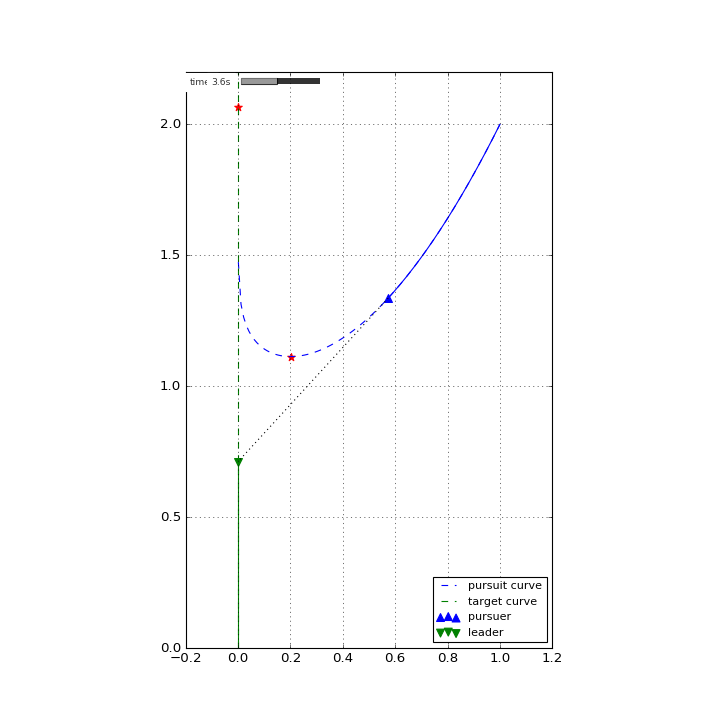

In [8]:
syst = StraightLinePursuit(q=.9,v=.2); ini = dict(xo=1.,yo=2.)
#syst = StraightLinePursuit(q=-.9,v=1.); ini = dict(xo=1.,yo=2.) # dual of previous one
#StraightLinePursuit(q=1.1,v=.2); ini = dict(xo=1.,yo=2.)
syst.launch(ini=syst.makestate(**ini))

### Semi-analytic solution when the target is a circle

We assume the origin of the referential frame is taken to be the centre of the target circle (of radius $\hat{R}$), and the horizontal axis to be the diameter of the circle going through point $\hat{A}$. The natural parametrisation of the target is hence given by
\begin{equation*}
\hat{x}(s) = \hat{R}\cos(\frac{s}{\hat{R}}) \hspace{2cm} \hat{y}(s) = \hat{R}\sin(\frac{s}{\hat{R}})
\end{equation*}
There is no obvious analytic parametrisation of the pursuit curve, but the equations can be transformed into the following ODE with a single variable $\phi$ and parameter $u$:
\begin{eqnarray*}
\phi' & = & \frac{q}{\frac{\sin^2(u)}{\sin(\phi)}+(q-\frac{\sin^2(u)}{\sin(\phi)})\frac{\tan(u)}{\tan(\phi)}}\\
\phi(u_o) & = & \theta_o+u_o \hspace{.5cm}\textrm{where}\hspace{.5cm} u_o=\arctan\left(\frac{\sin(\theta_o)}{\frac{r_o}{\hat{R}}-\cos(\theta_o)}\right)
\end{eqnarray*}
The other variables (in polar coordinates) are obtained by
\begin{equation*}
r = \hat{R}\frac{\sin(\phi)}{\sin(u)}
\hspace{2cm}
\theta' = \frac{\phi'-1}{1-q\frac{\sin(\phi)}{\sin^2(u)}}
\hspace{2cm}
\frac{q\ell}{\hat{R}} = \theta+u-\phi
\end{equation*}
or alternatively
\begin{equation*}
r = \hat{R}\frac{\sin(\phi)}{\sin(u)}
\hspace{2cm}
\frac{q\ell'}{\hat{R}} = \phi'(\frac{\tan(u)}{\tan(\phi)}-1)
\hspace{2cm}
\theta = \frac{q\ell}{\hat{R}}-u+\phi
\end{equation*}
Cartesian coordinates can of course be recovered by
\begin{equation*}
x = r\cos(\theta)
\hspace{2cm}
y = r\sin(\theta)
\end{equation*}
An empirical analysis indicates that, apart from singular cases:
* when $q<1$ the pursuit curve touches the target circle at a point where they have a common tangeant
* when $q>=1$ the pursuit curve asymptotically converges toward a circle with same centre as the target circle and of radius $\frac{\hat{R}}{q}$

In both cases, the pursuit curve may also intersect the target circle, but at points where the tangeants are distinct.

The program below augments the basic simulation by drawing, before the start of the simulation, a segment of the predicted pursuit curve, as well as its asymptotic circle when $q\geq1$. Note however that since that prediction is itself obtained by a numerical method, it is not so different from the simulation.

In [9]:
class CircularPursuit (Pursuit):

    def __init__(self,omega=1.0,R=1.,variant='Kell',safe=False,du=.001,**ka):
        super().__init__(F=(lambda t,pos,omega=omega: omega*array((-pos[1],pos[0]))),**ka)
        self.R = R
        def analytics(state,q=self.q,R=self.R):
            from scipy.integrate import ode
            def F(u,phi_s):
                phi,s = phi_s
                dphi = q*sin(phi)/(square(sin(u))+tan(u)*(q*cos(phi)-square(sin(u))/tan(phi)))
                ds = varF(u,phi,dphi)
                return array((dphi,ds))
            def varFtheta(u,phi,dphi): return (dphi-1)/(1-q*sin(phi)/square(sin(u)))
            def varFKell(u,phi,dphi): return dphi*(tan(u)/tan(phi)-1)
            def run(direc):
                r = ode(F).set_integrator('lsoda').set_initial_value((phio,so),uo)
                dt = direc*du
                while r.successful():
                    yield r.t,r.y
                    if safe and abs(r.t+dt)>pi/2: break
                    r.integrate(r.t+dt)
            xo,yo = state[0:2]
            ro = norm((xo,yo))
            thetao = arctan2(yo,xo)
            xoo = xo-square(ro)/R
            uo = -arctan(yo/xoo)
            phio = thetao+uo
            q *= sign(xoo)
            varF,so = dict(theta=(varFtheta,thetao),Kell=(varFKell,0.))[variant]
            L = list(run(-1.)); n = len(L); del L[0]
            L.reverse(); L.extend(run(1.))
            Lu,Lphi,Ls = array(list((u,phi,s) for u,(phi,s) in L)).T
            Lr = R*sin(Lphi)/sin(Lu)
            Ltheta,LKell = dict(theta=(Ls,Ls+Lu-Lphi),Kell=(Ls-Lu+Lphi,Ls))[variant]
            if n == len(L): n -= 1
            return n,Lu,Lphi,Lr,Ltheta,LKell
        self.analytics = analytics

    def display(self,ax,ini=None,**ka):
        from matplotlib.patches import Circle
        n,Lu,Lphi,Lr,Ltheta,LKell = self.analytics(ini)
        Lx,Ly = Lr*cos(Ltheta),Lr*sin(Ltheta)
        nstar = argmin(norm((Lx-self.R*cos(LKell),Ly-self.R*sin(LKell))))
        ax.plot(Lx,Ly,c='b',ls='--',label='pursuit curve')
        ax.scatter((Lx[nstar],),(Ly[nstar],),marker='*',color='r',s=50)
        ax.add_patch(Circle((0.,0.),self.R,ec='g',fc='none',ls='--',label='target curve'))
        if abs(self.q)>=1: ax.add_patch(Circle((0.,0.),self.R/abs(self.q),ec='b',fc='none',ls='--'))
        for i in 0,-1: ax.annotate(r'${:.1f}\frac{{\pi}}{{2}}$'.format(Lu[i]*2/pi),(Lx[i],Ly[i]),fontsize='x-small',zorder=1)
        ax.scatter((Lx[0],Lx[-1]),(Ly[0],Ly[-1]),marker='.',color='r')
        return super().display(ax,ini=ini,**ka)

    @staticmethod
    def makestate(xo,yo): return array((xo,yo,1.,0.))

Launchers
---------

System parameters:
* `q`: the arc length ratio between target and pursuit curve
* `R`: radius of the circular target (in m)
* `omega`: angular speed of the leader along the (circular) target (in sec$^{-1}$)
* `variant`: either 'theta' or 'Kell' specifying which variable $\theta$ or $\frac{q\ell}{\hat{R}}$ is solved by integration in the primary ODE
* `safe`: whether to stop primary ODE resolution at $u=\pm\frac{\pi}{2}$

Launch parameters:
* `ini/xo`, `ini/yo`: departure point of the pursuer (in m); the leader departs form $1,0$
* `srate`: simulation rate (in frames.sec$^{-1}$)
* `taild`: duration of shadow, ie. trace of previous states (in sec)
* `hooks`: list of display hooks (see doc)

<IPython.core.display.Javascript object>


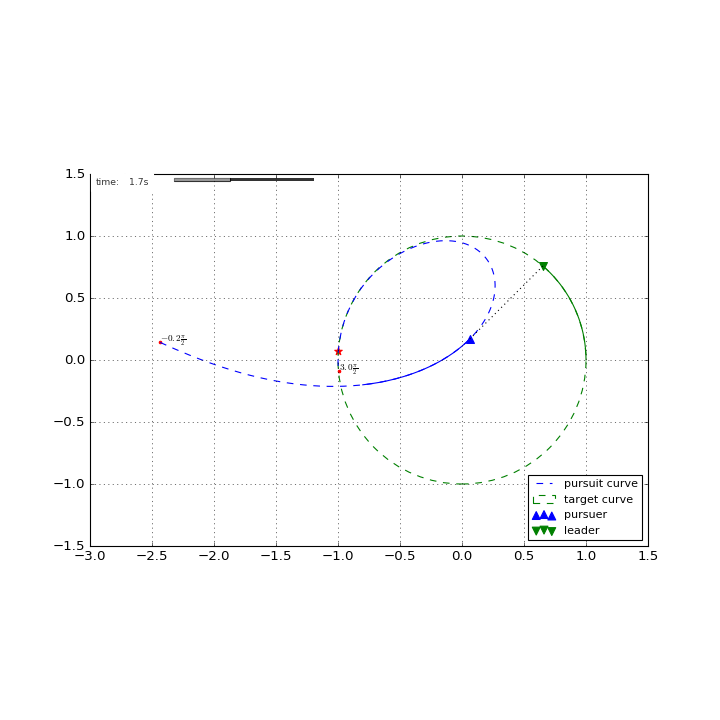

/Applications/anaconda/lib/python3.5/site-packages/scipy/integrate/_ode.py:1213: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  'Unexpected istate=%s' % istate))


In [17]:
syst = CircularPursuit(q=.9,omega=.5); ini = dict(xo=-.8,yo=-.2)
#syst = CircularPursuit(q=-.9,omega=.5); ini = dict(xo=-.8,yo=-.2) # dual of previous
#syst = CircularPursuit(q=.5,omega=.1); ini = dict(xo=.5,yo=-.1)
#syst = CircularPursuit(q=.5,omega=.05); ini = dict(xo=-.2,yo=.4)
#syst = CircularPursuit(q=-1.3,omega=.1); ini = dict(xo=.3,yo=.5)
#syst = CircularPursuit(q=1.3,omega=1.); ini = dict(xo=-3.,yo=-1.)
syst.launch(ini=syst.makestate(**ini))